In [2]:
import cv2
from cv2 import aruco
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import os
import matplotlib.pyplot as plt

In [3]:
_pth = os.getcwd()
_pth = os.path.dirname(_pth)
_parent_folder = "paper"
_calib_folder_name = "calibration_rs"


_base_pth = os.path.join(_pth,"recorded_data",_parent_folder)

_webcam_calib_folder = os.path.join(_pth,"recorded_data",_parent_folder,_calib_folder_name)
_webcam_calib_video = os.path.join(_webcam_calib_folder,"webcam_color.msgpack")
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join( _webcam_calib_folder, "webcam_calibration.msgpack")

In [4]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_ORIGINAL)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

board = aruco.GridBoard(
        size= [1,1],
        markerLength=markerLength,
        markerSeparation=markerSeperation,
        dictionary=ARUCO_DICT)

In [5]:
_video_pth = _webcam_calib_video
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)
_video_length = 0

for _frame in _video_data:
    _video_length += 1

_video_file.close()

In [6]:
_video_pth = _webcam_calib_video
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

marker_corners = []
object_points = []
first = True
counter = []
rnd = np.random.choice(_video_length, 150, replace=False)
for idx, _frame in enumerate(_video_data):
    
    if idx in rnd:
        # _frame = cv2.cvtColor(_frame, cv2.COLOR_BGR2GRAY)
        corners, ids, rejected_image_points = aruco.detectMarkers(_frame, ARUCO_DICT, parameters=ARUCO_PARAMETERS)
        try:
            if first == True:
                corners_list = corners
                id_list = ids
                first = False
            else:
                corners_list = np.vstack((corners_list, corners))
                id_list = np.vstack((id_list,ids))
            counter.append(len(ids))
        except:
            continue
_video_file.close()

counter = np.array(counter)

In [7]:
calibration_flags = cv2.CALIB_RATIONAL_MODEL
term_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)

In [8]:
mtx2 = np.zeros((3, 3))
dist2 = np.zeros((1, 8))
rvec2 = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(len(counter))]
tvec2 = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(len(counter))]

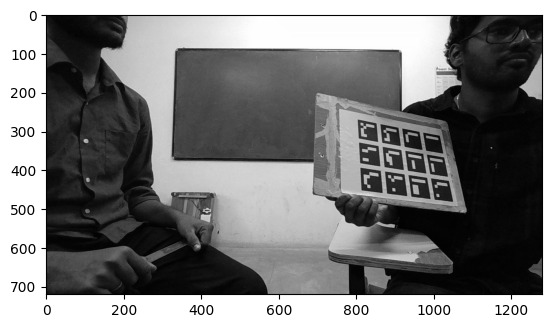

In [9]:
plt.imshow(_frame, cmap='gray')

In [10]:
_frame.shape

(720, 1280)

In [11]:
# ret1, mtx1, dist1, rvecs1, tvecs1 = aruco.calibrateCameraAruco(corners_list, id_list, counter, board, _frame.shape[:2], mtx2, dist2, flags=calibration_flags, criteria = term_criteria)
ret1, mtx1, dist1, rvecs1, tvecs1 = aruco.calibrateCameraAruco(corners_list, id_list, counter, board, _frame.shape[:2], mtx2, dist2)

In [12]:
with open(os.path.join(os.path.dirname(_webcam_calib_video), "camera_calibration_rs.msgpack"), "wb") as p:
    pckd = mp.packb((mtx1, dist1), default=mpn.encode)
    p.write(pckd)
    p.close()

In [16]:
focal_l1 = 658.224
focal_l2 = 658.224

p1 = 644.746
p2 = 361.722


dist1

array([[ 0.30391397,  0.29258142,  0.028164  , -0.13228185, -0.19334811]])

: 

In [14]:
import toml
data = toml.load('settings.toml')
data['calibration']['camera_matrix'] = mtx1.tolist()
data['calibration']['dist_coeffs'] = dist1.tolist()
with open('settings.toml', 'w') as f:
    toml.dump(data, f)